In [1]:
import sys

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

# 1. Load data, prep & train test split

In [3]:
# df = pd.read_csv("../datasets/churn/telco_churn.csv")
df = pd.read_csv("C:/Users/stijn/OneDrive/Bureaublad/TEW 1ste jaar/python thesis/End-to-end-project---Customer-churn/datasets/churn/telco_churn.csv")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
# RAW_DATA_PATH = "../datasets/churn/telco_churn.csv"
RAW_DATA_PATH = "C:/Users/stijn/OneDrive/Bureaublad/TEW 1ste jaar/python thesis/End-to-end-project---Customer-churn/datasets/churn/telco_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
# df = pd.read_csv(RAW_DATA_PATH)
# df = df.rename(columns=dict(
#     zip(df.columns, list(map(to_snake_case, df.columns)))))

# print(df.shape[0])
# df.churn.value_counts()/df.shape[0]*100

In [4]:
y = "customer_status"

# some generic cleaning
df["avg_monthly_long_distance_charges"] = df["avg_monthly_long_distance_charges"].fillna(0.0)
df["multiple_lines"] = df["multiple_lines"].fillna('no phone service')
df["avg_monthly_gb_download"] = df["avg_monthly_gb_download"].fillna(0)
no_internet = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv','streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet] = df[no_internet].fillna('no internet service')
COLUMNS_TO_DROP = ["customer_id", "churn_category","churn_reason", "longitude", "latitude", "city"]
df = df[df[y] != "Joined"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [5]:
pd.set_option('display.max_columns', None)

# df.internet_type.isna().sum()
df.head()


,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


# 2. Model selection

In [6]:
df[y].value_counts()/len(df)

customer_status
Stayed     0.716345
Churned    0.283655
Name: count, dtype: float64

In [7]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['customer_status']),
                                        y = train['customer_status']                                                    
                                    )
class_weights = dict(zip(np.unique(train['customer_status']), class_weights))
class_weights

{'Churned': 1.762876254180602, 'Stayed': 0.6979608050847458}

In [8]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    # 'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.5, 0.7, 1]
    'logistic__class_weight': [{0:1,1:1},{0:1.762876254180602,1:0.6979608050847458},{0:1.5,1:1},{0:1,1:3}, {0:2,1:1}, {0:100,1:1}, {0:1,1:10}]
}

model = LogisticRegression()

MODEL_NAME = "logistic"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name=MODEL_NAME, param_grid=param_grid, verbose=1,
    step_names_to_remove=['under', 'over'])
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 196 candidates, totalling 980 fits
Best score: 0.9141255684733945
Best parameters: {'logistic__C': 100, 'logistic__class_weight': {0: 1, 1: 3}, 'logistic__penalty': 'l2', 'pca__n_components': 50}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'internet_type',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'streaming_music',
                                                   'unlimited_data', 'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('pca', PCA(n_components=50)),
                ('logistic',
                 LogisticRegression(C=100, class_weight={0: 1, 1: 3}))])

In [9]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [10]:
COLUMNS = [ "pca__n_components", "logistic__class_weight", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"] 

#"under__sampling_strategy", "over__sampling_strategy",

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS] # .sort_values(by=COLUMNS)

,pca__n_components,logistic__class_weight,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,15,"{0: 1, 1: 1}",1,l2,0.875023,0.007044
1,20,"{0: 1, 1: 1}",1,l2,0.875568,0.006613
2,25,"{0: 1, 1: 1}",1,l2,0.902361,0.006509
3,30,"{0: 1, 1: 1}",1,l2,0.910948,0.005992
4,35,"{0: 1, 1: 1}",1,l2,0.910970,0.006101
...,...,...,...,...,...,...
191,25,"{0: 1, 1: 10}",1000,l2,0.901811,0.005936
192,30,"{0: 1, 1: 10}",1000,l2,0.909990,0.005702
193,35,"{0: 1, 1: 10}",1000,l2,0.910229,0.005536
194,50,"{0: 1, 1: 10}",1000,l2,0.913596,0.005991


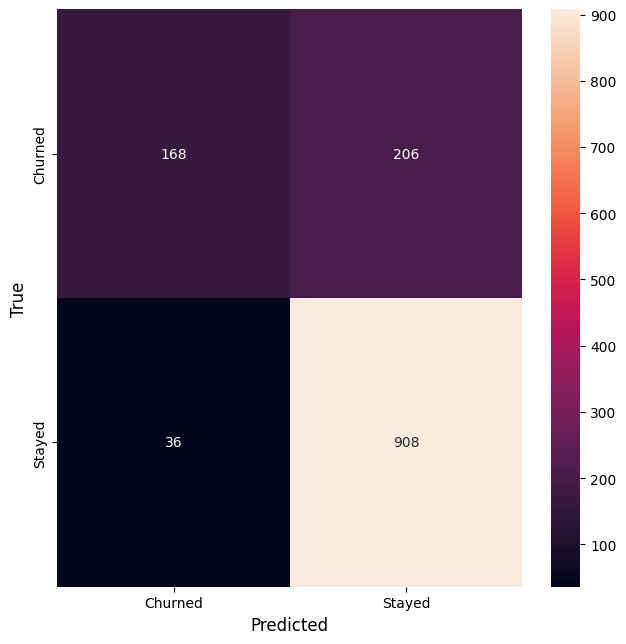

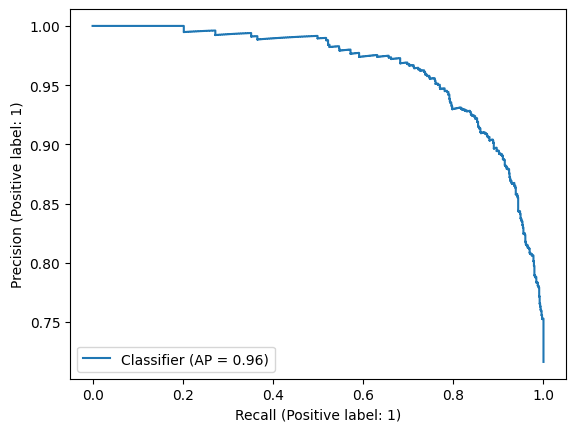

In [11]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [12]:
num_positive = np.sum(train == 'Stayed')
num_negative = np.sum(train == 'Churned')
scale_pos_weight = num_negative / num_positive
print(scale_pos_weight)

gender                                    NaN
age                                       NaN
married                                   NaN
number_of_dependents                      NaN
zip_code                                  NaN
number_of_referrals                       NaN
tenure_in_months                          NaN
offer                                     NaN
phone_service                             NaN
avg_monthly_long_distance_charges         NaN
multiple_lines                            NaN
internet_service                          NaN
internet_type                             NaN
avg_monthly_gb_download                   NaN
online_security                           NaN
online_backup                             NaN
device_protection_plan                    NaN
premium_tech_support                      NaN
streaming_tv                              NaN
streaming_movies                          NaN
streaming_music                           NaN
unlimited_data                    

In [13]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'xgb__scale_pos_weight':[ 0.1, 0.395922, 1,5, 10,15.815825, 50, 75, 100,  1000]

}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True, step_names_to_remove=['under', 'over'])
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score: 0.9100537948364036
Best parameters: {'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 0.395922, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 5, 'xgb__gamma': 5, 'xgb__colsample_bytree': 1.0, 'pca__n_components': 50}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [14]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

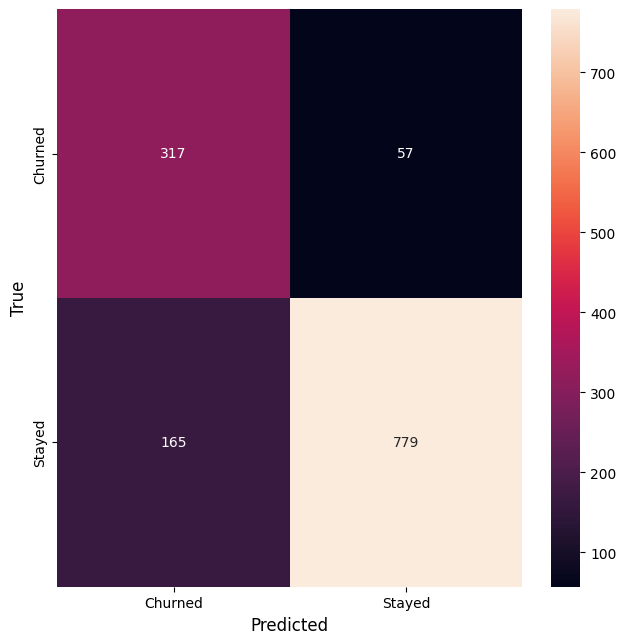

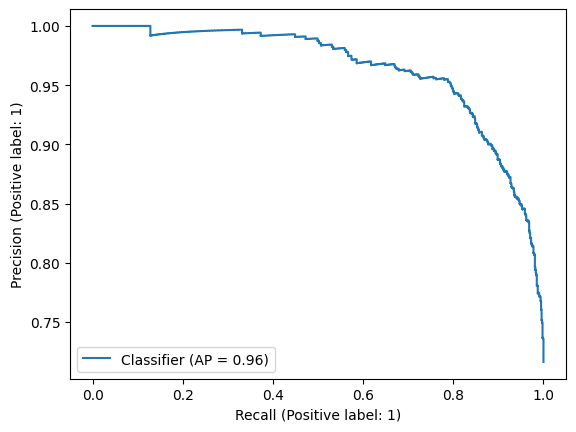

In [15]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [16]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# 3. Cost-based evaluation

In [17]:
TRUE_Y_ENCODED_COLUMN_NAME = "churn_encoded"
PREDICTED_Y_PROB_COLUMN_NAME_PREFIX = "y_predicted_proba"

In [18]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log[predicted_y_prob_col_name_log]= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
test_predictions_log[predicted_y_prob_col_name_log] = 1 - test_predictions_log[predicted_y_prob_col_name_log]
test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log["customer_status"])
test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["monthly_charge"]).to_frame())[:, 0]
test_predictions_log["y_predicted"] = 1 - test_predictions_log["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 171527.
 total cost/loss average :  130.14188163884674


In [19]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb[predicted_y_prob_col_name_xgb]
test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb["customer_status"])
test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["monthly_charge"]).to_frame())[:, 0]
test_predictions_xgb["y_predicted"] =  1- test_predictions_xgb["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))


Test cost/loss = 68497.
 total cost/loss average :  51.97018209408194


In [20]:
print(test_predictions_xgb[['customer_status', "A", 'instance_cost', "y_predicted"]].head(30))

     customer_status       A  instance_cost  y_predicted
4879          Stayed   67.45            0.0            0
1646          Stayed   69.65            0.0            0
777           Stayed   20.10            0.0            0
1163          Stayed   54.75            0.0            0
130           Stayed   48.80            0.0            0
3765         Churned   80.35          964.2            0
2533         Churned   75.30            0.0            1
1837          Stayed   19.90            0.0            0
302           Stayed   20.05            0.0            0
768           Stayed   39.40            0.0            0
1695         Churned   91.00         1092.0            0
1366         Churned   49.05            0.0            1
1058          Stayed   99.00            0.0            0
2474         Churned   86.20            0.0            1
1141          Stayed   19.80            0.0            0
2348          Stayed   19.95           39.9            1
2971         Churned   79.65   

# 3.1 AMC evaluation metric

In [21]:
test_predictions_log[predicted_y_prob_col_name_log]

4879    0.041542
1646    0.005409
777     0.017159
1163    0.011339
130     0.002869
          ...   
5340    0.030170
2641    0.666034
5796    0.706000
36      0.235394
5716    0.026074
Name: y_predicted_proba_log, Length: 1318, dtype: float64

In [22]:
test_predictions_log['A']

4879     67.45
1646     69.65
777      20.10
1163     54.75
130      48.80
         ...  
5340    105.05
2641     88.15
5796     94.10
36       89.80
5716     49.45
Name: A, Length: 1318, dtype: float64

Decision Threshold: 0.01, Test cost/loss = 70512.60
Decision Threshold: 0.02, Test cost/loss = 67042.80
Decision Threshold: 0.03, Test cost/loss = 62301.60
Decision Threshold: 0.04, Test cost/loss = 57422.30
Decision Threshold: 0.05, Test cost/loss = 58209.60
Decision Threshold: 0.06, Test cost/loss = 57704.80
Decision Threshold: 0.07, Test cost/loss = 56904.40
Decision Threshold: 0.08, Test cost/loss = 60036.50


Decision Threshold: 0.09, Test cost/loss = 61676.70
Decision Threshold: 0.10, Test cost/loss = 63832.40
Decision Threshold: 0.11, Test cost/loss = 63751.30
Decision Threshold: 0.12, Test cost/loss = 71751.50
Decision Threshold: 0.13, Test cost/loss = 71604.50
Decision Threshold: 0.14, Test cost/loss = 71161.30
Decision Threshold: 0.15, Test cost/loss = 70936.00
Decision Threshold: 0.16, Test cost/loss = 73730.40
Decision Threshold: 0.17, Test cost/loss = 75472.20
Decision Threshold: 0.18, Test cost/loss = 81178.30
Decision Threshold: 0.19, Test cost/loss = 83497.90
Decision Threshold: 0.20, Test cost/loss = 83943.60
Decision Threshold: 0.21, Test cost/loss = 84547.50
Decision Threshold: 0.22, Test cost/loss = 85050.00
Decision Threshold: 0.23, Test cost/loss = 88619.70
Decision Threshold: 0.24, Test cost/loss = 89076.90
Decision Threshold: 0.25, Test cost/loss = 94185.80
Decision Threshold: 0.26, Test cost/loss = 95296.90
Decision Threshold: 0.27, Test cost/loss = 98191.40
Decision Thr

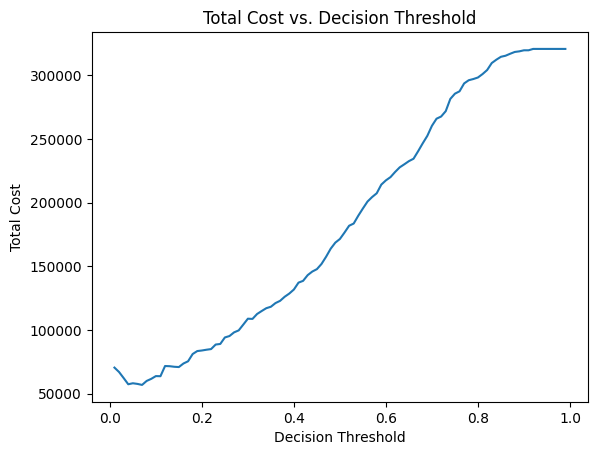

In [23]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(
    test=test_predictions_log, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log)

Decision Threshold: 0.01, Test cost/loss = 118528.90
Decision Threshold: 0.02, Test cost/loss = 114751.40
Decision Threshold: 0.03, Test cost/loss = 110753.20
Decision Threshold: 0.04, Test cost/loss = 104593.40
Decision Threshold: 0.05, Test cost/loss = 98272.80
Decision Threshold: 0.06, Test cost/loss = 91948.60
Decision Threshold: 0.07, Test cost/loss = 87692.70
Decision Threshold: 0.08, Test cost/loss = 84256.60
Decision Threshold: 0.09, Test cost/loss = 79042.70
Decision Threshold: 0.10, Test cost/loss = 77543.30
Decision Threshold: 0.11, Test cost/loss = 74621.00
Decision Threshold: 0.12, Test cost/loss = 71921.60
Decision Threshold: 0.13, Test cost/loss = 69490.30
Decision Threshold: 0.14, Test cost/loss = 69125.00
Decision Threshold: 0.15, Test cost/loss = 66544.50
Decision Threshold: 0.16, Test cost/loss = 66470.30
Decision Threshold: 0.17, Test cost/loss = 69137.90
Decision Threshold: 0.18, Test cost/loss = 70017.60
Decision Threshold: 0.19, Test cost/loss = 68103.30
Decision

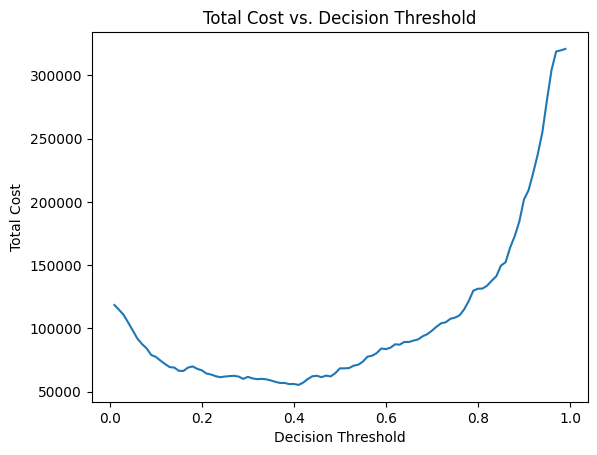

In [24]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(
    test=test_predictions_xgb, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb)

# 3.2 E-AMC evaluation metric


In [25]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [26]:
test_predictions_log

,gender,age,married,number_of_dependents,zip_code,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,y_predicted,y_predicted_proba_log,churn_encoded,A,instance_cost,y_predicted_decoded,TN,FN,FP,TP,EAP,EP
4879,Male,28,No,0,94612,0,40,NaN,Yes,39.05,No,Yes,DSL,58.0,Yes,No,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,67.45,2731.00,0.0,0,1562.00,4293.00,Stayed,0,0.041542,0,67.45,0.0,Churned,0,809.4,134.9,0,5.604047,38.261336
1646,Male,25,Yes,0,93212,6,50,Offer B,Yes,14.32,Yes,Yes,Cable,58.0,No,No,Yes,Yes,Yes,No,No,Yes,One Year,Yes,Bank Withdrawal,69.65,3442.15,0.0,0,716.00,4158.15,Stayed,0,0.005409,0,69.65,0.0,Churned,0,835.8,139.3,0,0.753431,39.509296
777,Female,38,No,0,93552,0,18,Offer D,Yes,18.80,No,No,no internet service,0.0,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,One Year,No,Mailed Check,20.10,407.05,0.0,0,338.40,745.45,Stayed,0,0.017159,0,20.10,0.0,Churned,0,241.2,40.2,0,0.689805,11.401821
1163,Female,51,No,0,92220,0,42,NaN,No,0.00,no phone service,Yes,DSL,13.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One Year,Yes,Bank Withdrawal,54.75,2348.45,0.0,80,0.00,2428.45,Stayed,0,0.011339,0,54.75,0.0,Churned,0,657.0,109.5,0,1.241644,31.057200
130,Male,69,No,0,95820,0,52,Offer B,No,0.00,no phone service,Yes,DSL,19.0,Yes,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,48.80,2555.05,0.0,0,0.00,2555.05,Stayed,0,0.002869,0,48.80,0.0,Churned,0,585.6,97.6,0,0.279984,27.682034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,Female,44,Yes,0,93437,1,20,NaN,No,0.00,no phone service,Yes,DSL,10.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,24.45,482.80,0.0,0,0.00,482.80,Churned,0,0.444857,1,24.45,293.4,Churned,0,293.4,48.9,0,162.878998,210.183722
2993,Male,54,Yes,0,93637,1,40,Offer B,Yes,22.56,Yes,Yes,Cable,4.0,No,Yes,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,101.30,4113.10,0.0,0,902.40,5015.50,Churned,1,0.769570,1,101.30,1215.6,Stayed,0,1215.6,202.6,0,280.110392,870.822538
3373,Female,64,Yes,0,92320,1,1,Offer E,Yes,21.65,No,Yes,Fiber Optic,13.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,68.95,68.95,0.0,0,21.65,90.60,Churned,1,0.896736,1,68.95,827.4,Stayed,0,827.4,137.9,0,85.440784,592.726693
4476,Female,54,No,0,91202,0,1,Offer E,No,0.00,no phone service,Yes,DSL,27.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,29.95,29.95,0.0,0,0.00,29.95,Churned,1,0.609673,1,29.95,359.4,Stayed,0,359.4,59.9,0,140.283563,257.464314


In [27]:
test[y].value_counts()

customer_status
Stayed     944
Churned    374
Name: count, dtype: int64

In [28]:
test_predictions_xgb[y].value_counts()

customer_status
Stayed     944
Churned    374
Name: count, dtype: int64

In [29]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

184486.74130575894
263426.64964902296
EAP :  139.97476578585656
EP :  199.86847469576855


In [30]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

105466.63904387355
263426.64964902296
EAP :  80.02021171765824
EP :  199.86847469576855


# MP metric at 50% threshold

In [31]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log_2 = test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2[predicted_y_prob_col_name_log] = best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
test_predictions_log_2[predicted_y_prob_col_name_log] = 1 - test_predictions_log_2[predicted_y_prob_col_name_log]
test_predictions_log_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log_2["customer_status"])
test_predictions_log_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log_2[TRUE_Y_ENCODED_COLUMN_NAME]
# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["monthly_charge"]).to_frame())[:, 0]
test_predictions_log_2["y_predicted"] = 1 - test_predictions_log_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -145758.
 total cost/loss average :  -110.5902124430956


In [32]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
test_predictions_xgb_2[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb_2[predicted_y_prob_col_name_xgb]
test_predictions_xgb_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb_2["customer_status"])
test_predictions_xgb_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb_2[TRUE_Y_ENCODED_COLUMN_NAME]
# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["monthly_charge"]).to_frame())[:, 0]
test_predictions_xgb_2["y_predicted"] = 1 - test_predictions_xgb_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -22554.
 total cost/loss average :  -17.11206373292868


# MP metric

Decision Threshold: 0.01, Test cost/loss = -17444.10
Decision Threshold: 0.02, Test cost/loss = -14800.50
Decision Threshold: 0.03, Test cost/loss = -10470.70
Decision Threshold: 0.04, Test cost/loss = -5731.60
Decision Threshold: 0.05, Test cost/loss = -7283.90
Decision Threshold: 0.06, Test cost/loss = -7209.40
Decision Threshold: 0.07, Test cost/loss = -6833.00
Decision Threshold: 0.08, Test cost/loss = -10876.90
Decision Threshold: 0.09, Test cost/loss = -13135.90
Decision Threshold: 0.10, Test cost/loss = -15956.10
Decision Threshold: 0.11, Test cost/loss = -16073.30
Decision Threshold: 0.12, Test cost/loss = -25641.30
Decision Threshold: 0.13, Test cost/loss = -25738.40
Decision Threshold: 0.14, Test cost/loss = -25463.60
Decision Threshold: 0.15, Test cost/loss = -25464.70
Decision Threshold: 0.16, Test cost/loss = -29021.80
Decision Threshold: 0.17, Test cost/loss = -31234.50
Decision Threshold: 0.18, Test cost/loss = -37932.20
Decision Threshold: 0.19, Test cost/loss = -40752.

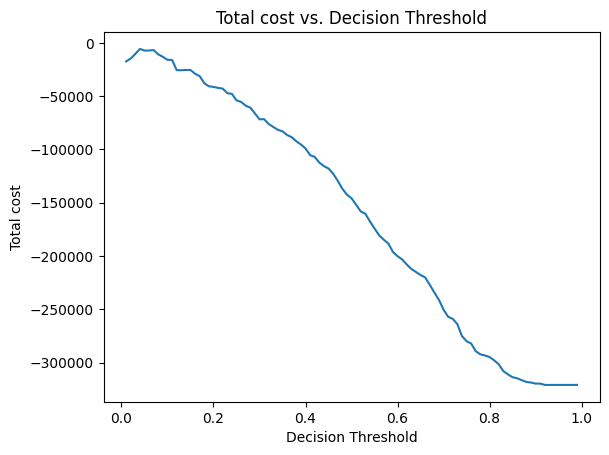

In [33]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(
    test=test_predictions_log_2, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log,
    instance_dependent_cost_type = 'churn_2')

Decision Threshold: 0.01, Test cost/loss = -65063.10
Decision Threshold: 0.02, Test cost/loss = -61285.60
Decision Threshold: 0.03, Test cost/loss = -57336.90
Decision Threshold: 0.04, Test cost/loss = -51177.10
Decision Threshold: 0.05, Test cost/loss = -44856.50
Decision Threshold: 0.06, Test cost/loss = -38532.30
Decision Threshold: 0.07, Test cost/loss = -34326.70
Decision Threshold: 0.08, Test cost/loss = -30999.30
Decision Threshold: 0.09, Test cost/loss = -25785.40
Decision Threshold: 0.10, Test cost/loss = -24518.40
Decision Threshold: 0.11, Test cost/loss = -21636.40
Decision Threshold: 0.12, Test cost/loss = -19125.80
Decision Threshold: 0.13, Test cost/loss = -16875.80
Decision Threshold: 0.14, Test cost/loss = -16669.20
Decision Threshold: 0.15, Test cost/loss = -14088.70
Decision Threshold: 0.16, Test cost/loss = -14233.10
Decision Threshold: 0.17, Test cost/loss = -17658.40
Decision Threshold: 0.18, Test cost/loss = -18932.10
Decision Threshold: 0.19, Test cost/loss = -17

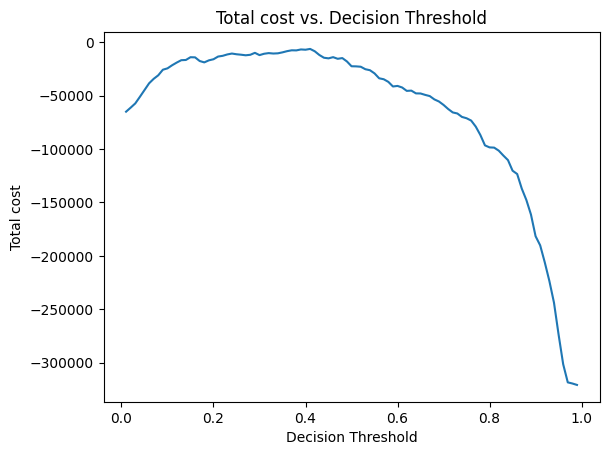

In [34]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(
    test=test_predictions_xgb_2, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb,instance_dependent_cost_type = 'churn_2')

# EMP metric

In [35]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [36]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-160006.0399924065
-248262.284063745
EAP :  -121.40063732352542
EP :  -188.36288623956372


In [37]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-64224.18902755976
-248262.284063745
EAP :  -48.72851974776917
EP :  -188.36288623956372


# cost curves

In [38]:
unique_values = test_predictions_log['y_predicted'].unique()
print(unique_values)

[0 1]


In [39]:
total_fp_log = 0

for i in range(0,1315):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/1315
print( average_fp_log)

5346.799999999999
4.066007604562737


In [40]:
total_fn_log = 0

for i in range(0,1315):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/1315
print( average_fn_log)

166180.19999999998
126.37277566539923


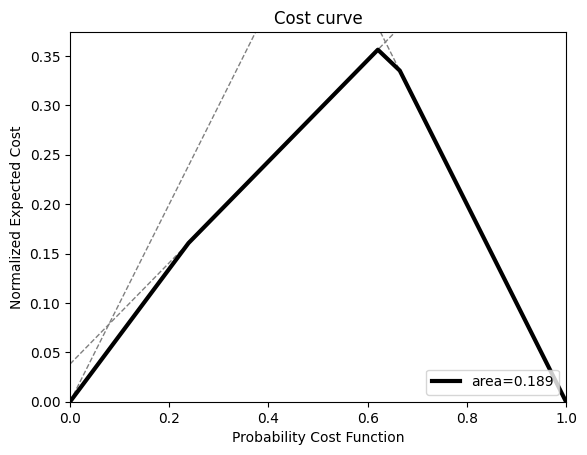

In [41]:
# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [42]:
total_fp_xgb = 0

for i in range(0,1315):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/1315
print( average_fp_xgb)

23359.899999999994
17.764182509505698


In [43]:
total_fn_xgb = 0

for i in range(0,1315):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/1315
print( average_fn_xgb)

45136.8
34.32456273764259


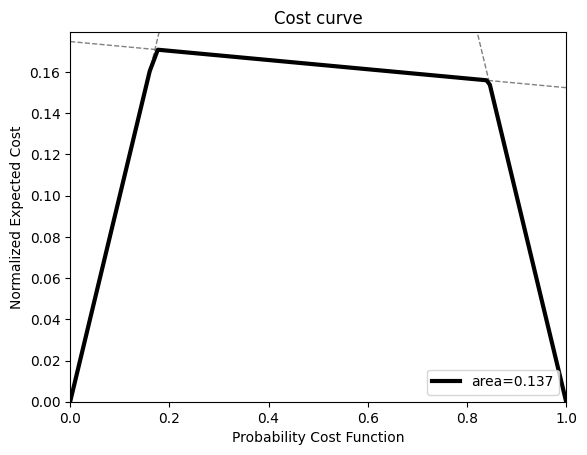

In [44]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the fraud detection cost and benefit matrices

# total cost 50% decision threshold

In [45]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log_fraud = test.copy(deep=True)
test_predictions_log_fraud["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud.drop(y, axis=1))
test_predictions_log_fraud[predicted_y_prob_col_name_log] = best_pipeline_log_reg.predict_proba(test_predictions_log_fraud.drop(y, axis=1))[:, 1]
test_predictions_log_fraud[predicted_y_prob_col_name_log] = 1 - test_predictions_log_fraud[predicted_y_prob_col_name_log]
test_predictions_log_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log_fraud["customer_status"])
test_predictions_log_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log_fraud[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud['A'] = impute.fit_transform(
    (test_predictions_log_fraud["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_log_fraud["y_predicted"] = 1 - test_predictions_log_fraud["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud['instance_cost'] = test_predictions_log_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud['instance_cost'].sum()/len(test_predictions_log_fraud))

Test cost/loss = 13884.
 total cost/loss average :  10.534408194233688


In [46]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb_fraud = test.copy(deep=True)
test_predictions_xgb_fraud["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud.drop(y, axis=1))
test_predictions_xgb_fraud[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud.drop(y, axis=1))[:, 1]
test_predictions_xgb_fraud[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb_fraud[predicted_y_prob_col_name_xgb]
test_predictions_xgb_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb_fraud["customer_status"])
test_predictions_xgb_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb_fraud[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_xgb_fraud["y_predicted"] = 1 - test_predictions_xgb_fraud["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud['instance_cost'] = test_predictions_xgb_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud['instance_cost'].sum()/len(test_predictions_xgb_fraud))

Test cost/loss = 3926.
 total cost/loss average :  2.9790591805766313


In [47]:
print(test_predictions_xgb_fraud[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']])

     customer_status y_predicted_decoded         A  instance_cost
4879          Stayed             Churned  134900.0            0.0
1646          Stayed             Churned  139300.0            0.0
777           Stayed             Churned   40200.0            0.0
1163          Stayed             Churned  109500.0            0.0
130           Stayed             Churned   97600.0            0.0
...              ...                 ...       ...            ...
5340          Stayed             Churned  210100.0            0.0
2641         Churned              Stayed  176300.0            0.0
5796          Stayed              Stayed  188200.0            1.0
36            Stayed             Churned  179600.0            0.0
5716          Stayed             Churned   98900.0            0.0

[1318 rows x 4 columns]


# amc metric

Decision Threshold: 0.01, Test cost/loss = 680.65
Decision Threshold: 0.02, Test cost/loss = 1032.75
Decision Threshold: 0.03, Test cost/loss = 1185.45
Decision Threshold: 0.04, Test cost/loss = 1213.55
Decision Threshold: 0.05, Test cost/loss = 1568.05
Decision Threshold: 0.06, Test cost/loss = 1762.20
Decision Threshold: 0.07, Test cost/loss = 1948.20
Decision Threshold: 0.08, Test cost/loss = 2390.10
Decision Threshold: 0.09, Test cost/loss = 2685.50
Decision Threshold: 0.10, Test cost/loss = 3005.75
Decision Threshold: 0.11, Test cost/loss = 3095.90
Decision Threshold: 0.12, Test cost/loss = 3869.80
Decision Threshold: 0.13, Test cost/loss = 3978.85
Decision Threshold: 0.14, Test cost/loss = 4053.05
Decision Threshold: 0.15, Test cost/loss = 4155.25
Decision Threshold: 0.16, Test cost/loss = 4523.60
Decision Threshold: 0.17, Test cost/loss = 4753.05
Decision Threshold: 0.18, Test cost/loss = 5246.85
Decision Threshold: 0.19, Test cost/loss = 5492.10
Decision Threshold: 0.20, Test c

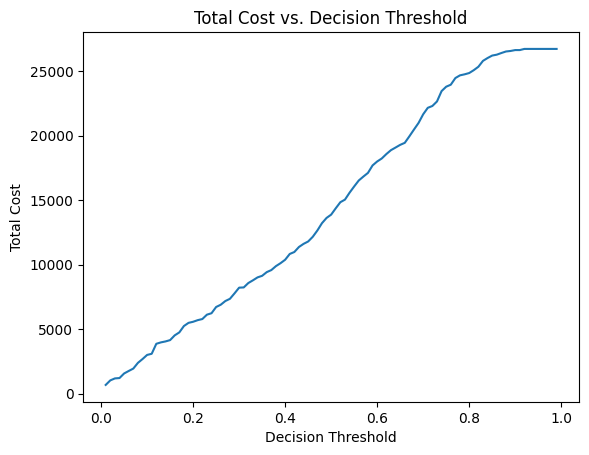

In [48]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(
    test=test_predictions_log_fraud, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log,
    instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 944.00
Decision Threshold: 0.02, Test cost/loss = 882.00
Decision Threshold: 0.03, Test cost/loss = 838.75
Decision Threshold: 0.04, Test cost/loss = 775.75
Decision Threshold: 0.05, Test cost/loss = 722.75
Decision Threshold: 0.06, Test cost/loss = 667.75
Decision Threshold: 0.07, Test cost/loss = 656.90
Decision Threshold: 0.08, Test cost/loss = 682.25
Decision Threshold: 0.09, Test cost/loss = 645.25
Decision Threshold: 0.10, Test cost/loss = 738.45
Decision Threshold: 0.11, Test cost/loss = 737.60
Decision Threshold: 0.12, Test cost/loss = 807.00
Decision Threshold: 0.13, Test cost/loss = 874.65
Decision Threshold: 0.14, Test cost/loss = 942.00
Decision Threshold: 0.15, Test cost/loss = 925.00
Decision Threshold: 0.16, Test cost/loss = 1024.30
Decision Threshold: 0.17, Test cost/loss = 1390.15
Decision Threshold: 0.18, Test cost/loss = 1576.15
Decision Threshold: 0.19, Test cost/loss = 1561.15
Decision Threshold: 0.20, Test cost/loss = 162

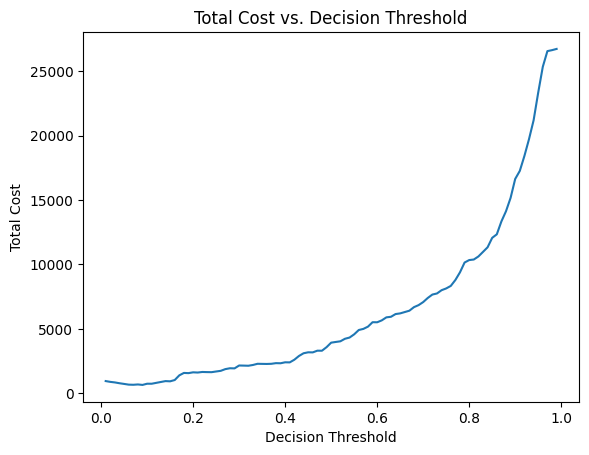

In [49]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(
    test=test_predictions_xgb_fraud, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb,instance_dependent_cost_type = 'fraud')

# e-amc metric

In [50]:
test_predictions_log_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud")
test_predictions_xgb_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [51]:
print(test_predictions_log_fraud['EAP'].sum())
print(test_predictions_log_fraud['EP'].sum())


print('EAP : ', test_predictions_log_fraud['EAP'].sum()/len(test_predictions_log_fraud))
print('EP : ', test_predictions_log_fraud['EP'].sum()/len(test_predictions_log_fraud))

14565.64444506141
19418.461468412064
EAP :  11.051323554674818
EP :  14.733278807596406


In [52]:
print(test_predictions_xgb_fraud['EAP'].sum())
print(test_predictions_xgb_fraud['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud['EAP'].sum()/len(test_predictions_xgb_fraud))
print('EP : ', test_predictions_xgb_fraud['EP'].sum()/len(test_predictions_xgb_fraud))

6337.325071629883
19418.461468412064
EAP :  4.808289128702491
EP :  14.733278807596406


# MP at 50% threshold

In [53]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log_fraud_2 = test.copy(deep=True)
test_predictions_log_fraud_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud_2.drop(y, axis=1))
test_predictions_log_fraud_2[predicted_y_prob_col_name_log] = best_pipeline_log_reg.predict_proba(test_predictions_log_fraud_2.drop(y, axis=1))[:, 1]
test_predictions_log_fraud_2[predicted_y_prob_col_name_log] = 1 - test_predictions_log_fraud_2[predicted_y_prob_col_name_log]
test_predictions_log_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log_fraud_2["customer_status"])
test_predictions_log_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud_2['A'] = impute.fit_transform(
    (test_predictions_log_fraud_2["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_log_fraud_2["y_predicted"] = 1 - test_predictions_log_fraud_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud_2['instance_cost'] = test_predictions_log_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud_2['instance_cost'].sum()/len(test_predictions_log_fraud_2))

Test cost/loss = -13716.
 total cost/loss average :  -10.406942336874051


In [54]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb_fraud_2 = test.copy(deep=True)
test_predictions_xgb_fraud_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud_2.drop(y, axis=1))
test_predictions_xgb_fraud_2[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud_2.drop(y, axis=1))[:, 1]
test_predictions_xgb_fraud_2[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb_fraud_2[predicted_y_prob_col_name_xgb]
test_predictions_xgb_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb_fraud_2["customer_status"])
test_predictions_xgb_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud_2['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud_2["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_xgb_fraud_2["y_predicted"] = 1 - test_predictions_xgb_fraud_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud_2['instance_cost'] = test_predictions_xgb_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud_2['instance_cost'].sum()/len(test_predictions_xgb_fraud_2))


Test cost/loss = -3609.
 total cost/loss average :  -2.7385432473444613


# MP-metric

Decision Threshold: 0.01, Test cost/loss = -310.65
Decision Threshold: 0.02, Test cost/loss = -669.75
Decision Threshold: 0.03, Test cost/loss = -826.45
Decision Threshold: 0.04, Test cost/loss = -855.55
Decision Threshold: 0.05, Test cost/loss = -1215.05
Decision Threshold: 0.06, Test cost/loss = -1411.20
Decision Threshold: 0.07, Test cost/loss = -1601.20
Decision Threshold: 0.08, Test cost/loss = -2049.10
Decision Threshold: 0.09, Test cost/loss = -2348.50
Decision Threshold: 0.10, Test cost/loss = -2672.75
Decision Threshold: 0.11, Test cost/loss = -2765.90
Decision Threshold: 0.12, Test cost/loss = -3550.80
Decision Threshold: 0.13, Test cost/loss = -3661.85
Decision Threshold: 0.14, Test cost/loss = -3738.05
Decision Threshold: 0.15, Test cost/loss = -3842.25
Decision Threshold: 0.16, Test cost/loss = -4215.60
Decision Threshold: 0.17, Test cost/loss = -4448.05
Decision Threshold: 0.18, Test cost/loss = -4947.85
Decision Threshold: 0.19, Test cost/loss = -5197.10
Decision Thresho

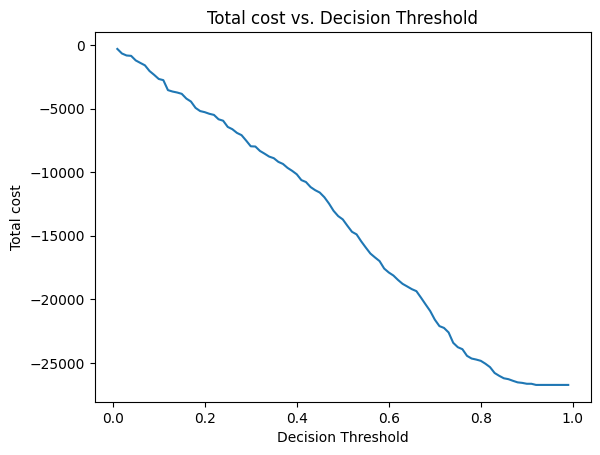

In [55]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(
    test=test_predictions_log_fraud_2, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log,
    instance_dependent_cost_type = 'fraud_2')

Decision Threshold: 0.01, Test cost/loss = -570.00
Decision Threshold: 0.02, Test cost/loss = -508.00
Decision Threshold: 0.03, Test cost/loss = -465.75
Decision Threshold: 0.04, Test cost/loss = -402.75
Decision Threshold: 0.05, Test cost/loss = -349.75
Decision Threshold: 0.06, Test cost/loss = -294.75
Decision Threshold: 0.07, Test cost/loss = -284.90
Decision Threshold: 0.08, Test cost/loss = -311.25
Decision Threshold: 0.09, Test cost/loss = -274.25
Decision Threshold: 0.10, Test cost/loss = -368.45
Decision Threshold: 0.11, Test cost/loss = -368.60
Decision Threshold: 0.12, Test cost/loss = -439.00
Decision Threshold: 0.13, Test cost/loss = -508.65
Decision Threshold: 0.14, Test cost/loss = -578.00
Decision Threshold: 0.15, Test cost/loss = -561.00
Decision Threshold: 0.16, Test cost/loss = -662.30
Decision Threshold: 0.17, Test cost/loss = -1032.15
Decision Threshold: 0.18, Test cost/loss = -1220.15
Decision Threshold: 0.19, Test cost/loss = -1205.15
Decision Threshold: 0.20, Te

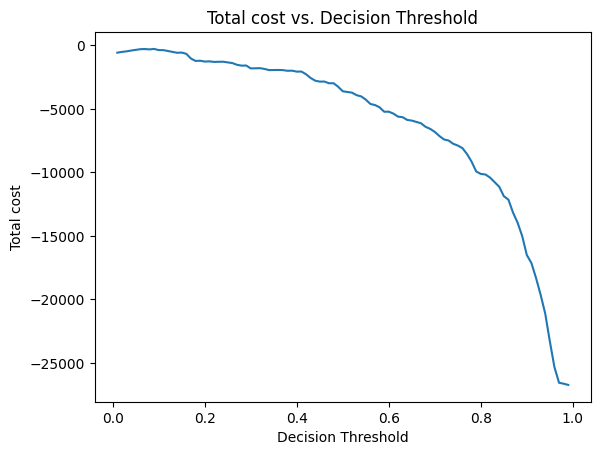

In [56]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(
    test=test_predictions_xgb_fraud_2, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb,instance_dependent_cost_type = 'fraud_2')

# EMP-metric

In [57]:
test_predictions_log_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [58]:
print(test_predictions_log_fraud_2['EAP'].sum())
print(test_predictions_log_fraud_2['EP'].sum())


print('EAP : ', test_predictions_log_fraud_2['EAP'].sum()/len(test_predictions_log_fraud_2))
print('EP : ', test_predictions_log_fraud_2['EP'].sum()/len(test_predictions_log_fraud_2))

-14400.073372030087
-19312.3848226143
EAP :  -10.925700585758792
EP :  -14.652795768296132


In [59]:
print(test_predictions_xgb_fraud_2['EAP'].sum())
print(test_predictions_xgb_fraud_2['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud_2['EAP'].sum()/len(test_predictions_xgb_fraud_2))
print('EP : ', test_predictions_xgb_fraud_2['EP'].sum()/len(test_predictions_xgb_fraud_2))

-6053.625152584911
-19312.3848226143
EAP :  -4.593038810762452
EP :  -14.652795768296132


# cost curves

In [60]:
total_fp_log_2 = 0

for i in range(0,1315):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_log_fraud['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_fraud['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/1315
print( average_fp_log_2)

36
0.02737642585551331


In [61]:
total_fn_log_2 = 0

for i in range(0,1315):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_log_fraud['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_fraud['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/1315
print( average_fn_log_2)

13848.350000000002
10.531064638783272


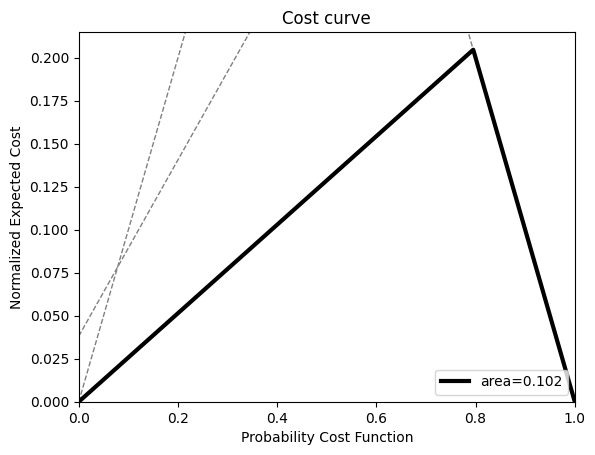

In [62]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [63]:
total_fp_xgb_2 = 0

for i in range(0,1315):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_fraud['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/1315
print( average_fp_xgb_2)

165
0.12547528517110265


In [64]:
total_fn_xgb_2 = 0

for i in range(0,1315):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_fraud['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/1315
print( average_fn_xgb_2)

3761.3999999999996
2.860380228136882


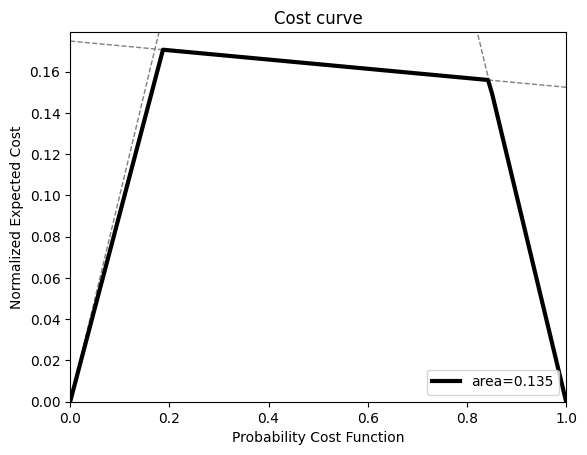

In [65]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()